# Test with pretrained models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_
import torch.nn.init as init
from sklearn.utils.class_weight import compute_class_weight
import random
import numpy as np
import os
import cpuinfo
from tqdm import tqdm
from torchinfo import summary
from PIL import Image

In [2]:
# Control randomness
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### File paths

In [3]:
train_path = "../data/Train"        # paths for your training and testing dataset
#train_path = "../data/aug_train"    
test_path = "../data/Test"          # using test dataset as validation too
input_parameter = ""                # paths for import and export custom model trainable parameters
output_parameter = ""

### Device of use

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
device_name = ""

print(f"CPU count: {os.cpu_count()}")
num_workers = min(4, os.cpu_count() // 2)  # Dynamically set num_workers
print(f"Using device: {device}")

CPU count: 16
Using device: cuda


### Pretrain Model of use from torchvision

In [5]:
from torchvision.models import efficientnet_v2_s
model = efficientnet_v2_s(weights='DEFAULT')
img_size = 384 # adjust input image size for model
print(f"Using model {type(model).__name__}")

epochs = 120
batch_size = 16 # adjust to your memory
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,            # learning rate
    weight_decay=1e-3,  # L2 regularization
    betas=(0.9, 0.999), # Adam beta parameters
    )
grad_clip = 2.0         # gradient clipping value
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=1,
    min_lr=1e-10,
    cooldown=0
    )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,            # number of iterations for the first restart
#     T_mult=2,          # increase T_0 after each restart
#     eta_min=1e-10,      # minimum learning rate
#     )
# loss_function = nn.CrossEntropyLoss() defined in Weighed Cross Entropy Loss cell

Using model EfficientNet


### Data transform/normalization and loader

In [26]:
transform_train = transforms.Compose([
    transforms.Resize(450),

    transforms.Pad(padding=150, padding_mode='edge'),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomRotation(45, expand=False, fill=0),

    transforms.CenterCrop(450),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), ratio=(0.1, 10), value='random', inplace=False),
])

transform_test = transforms.Compose([   # on test dataset
    transforms.Resize(img_size),
    transforms.CenterCrop((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [7]:
train_dataset = datasets.ImageFolder(root=train_path, transform=tr)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

val_data = [
    (images.to(device), labels.to(device))
    for images, labels in tqdm(test_loader, desc=f"Preloading Val Data to {device_name}", leave=False)
]

class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

print(f"Total Classes: {len(train_dataset.classes)}")
print(f"Class counts: {class_counts}")
print(f"Classes: {train_dataset.classes}")

Total Classes: 9
Class counts: [114, 376, 95, 438, 357, 462, 77, 181, 139]
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Weighted Cross Entropy Loss

In [8]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(train_dataset.classes)),
    y=[label for _, label in train_dataset.samples]
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

print(f"Class weights: {class_weights}")

Class weights: tensor([2.1823, 0.6616, 2.6187, 0.5680, 0.6969, 0.5385, 3.2309, 1.3745, 1.7898],
       device='cuda:0')


### Model Classifier layer

In [9]:
# Edit the output layer of the model
num_classes = len(train_dataset.classes)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1280, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Initialize weights and biases for classifier[1]
# init.kaiming_normal_(model.classifier[1].weight, mode='fan_in', nonlinearity='relu')
# model.classifier[1].bias.data.fill_(0.0)

print(f"Classifier - Input features: {num_features}, Output classes: {num_classes}")

Classifier - Input features: 1280, Output classes: 9


### Configure model parameters

In [10]:
# IF NEEDED
# Load custom weight and optimizer states
# if os.path.exists(input_parameter):
#     checkpoint = torch.load("test_weights.pth", map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
# # Selective layer freezing
# # change base on your model
# # "Early layers are often already well-optimized" by GPT-4o
# for _, param in model.named_parameters():
#     param.requires_grad = True          # Unfreeze all layers first
# for name, param in model.named_parameters():
#     if "classifier" not in name:
#         param.requires_grad = False     # Freeze everything except the last classifier layer

In [12]:
# Move model to device
model.to(device)
print(f"Model is on {next(model.parameters()).device}")

Model is on cuda:0


In [13]:
# Print model architecture
print(summary(model, (batch_size, 3, img_size, img_size)))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 9]                   --
├─Sequential: 1-1                                       [16, 1280, 12, 12]        --
│    └─Conv2dNormActivation: 2-1                        [16, 24, 192, 192]        --
│    │    └─Conv2d: 3-1                                 [16, 24, 192, 192]        648
│    │    └─BatchNorm2d: 3-2                            [16, 24, 192, 192]        48
│    │    └─SiLU: 3-3                                   [16, 24, 192, 192]        --
│    └─Sequential: 2-2                                  [16, 24, 192, 192]        --
│    │    └─FusedMBConv: 3-4                            [16, 24, 192, 192]        5,232
│    │    └─FusedMBConv: 3-5                            [16, 24, 192, 192]        5,232
│    └─Sequential: 2-3                                  [16, 48, 96, 96]          --
│    │    └─FusedMBConv: 3-6                         

In [14]:
# # DEBUG
# print(f"Model device: {next(model.parameters()).device}")
# for images, labels in train_data:
#     print(f"Input device: {images.device}")
#     break
# print(f"Device: {device}")

## Training Epochs

In [15]:
%time  # IPython magic command for timing
arr_train_loss = []
arr_train_acc = []
arr_val_loss = []
arr_val_acc = []

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    current_lr = scheduler.get_last_lr()[0]
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        # --Non-Mixed Precision training--
        outputs = model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        clip_grad_norm_(model.parameters(), grad_clip)  # Gradient clipping
        optimizer.step()
        # --Non-Mixed Precision training--

        # Calculate statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update progress bar
        train_bar.set_postfix({
            'loss': f"{running_loss / total_train:.4f}",
            'acc': f"{100. * correct_train / total_train:.2f}%"
        })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(val_data, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Update progress bar
            val_bar.set_postfix({
                'loss': f"{val_loss / total_val:.4f}",
                'acc': f"{100. * correct_val / total_val:.2f}%"
            })

    # Update learning rate
    if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) or isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
        scheduler.step()
    else:
        scheduler.step(val_loss / total_val)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Learning Rate: {current_lr:.10f} | "
          f"Train Loss: {running_loss / total_train:.4f}, Train Acc: {100. * correct_train / total_train:.2f}% | "
          f"Val Loss: {val_loss / total_val:.4f}, Val Acc: {100. * correct_val / total_val:.2f}%")
    
    # Save training and validation loss and accuracy
    arr_train_loss.append(running_loss / total_train)
    arr_train_acc.append(100. * correct_train / total_train)
    arr_val_loss.append(val_loss / total_val)
    arr_val_acc.append(100. * correct_val / total_val)

CPU times: total: 0 ns
Wall time: 0 ns


Epoch 1/120 - Learning Rate: 0.0003000000 | Train Loss: 1.9296, Train Acc: 35.82% | Val Loss: 1.7700, Val Acc: 54.24%


Epoch 2/120 - Learning Rate: 0.0003000000 | Train Loss: 1.6000, Train Acc: 54.22% | Val Loss: 1.7933, Val Acc: 48.31%


Epoch 3/120 - Learning Rate: 0.0003000000 | Train Loss: 1.4853, Train Acc: 60.56% | Val Loss: 1.6201, Val Acc: 57.63%


Epoch 4/120 - Learning Rate: 0.0003000000 | Train Loss: 1.4070, Train Acc: 64.18% | Val Loss: 1.6697, Val Acc: 61.02%


Epoch 5/120 - Learning Rate: 0.0003000000 | Train Loss: 1.3394, Train Acc: 68.24% | Val Loss: 1.6621, Val Acc: 63.56%


Epoch 6/120 - Learning Rate: 0.0001500000 | Train Loss: 1.2438, Train Acc: 71.73% | Val Loss: 1.5789, Val Acc: 66.10%


Epoch 7/120 - Learning Rate: 0.0001500000 | Train Loss: 1.1784, Train Acc: 76.28% | Val Loss: 1.6431, Val Acc: 65.25%


Epoch 8/120 - Learning Rate: 0.0001500000 | Train Loss: 1.1327, Train Acc: 77.09% | Val Loss: 1.5793, Val Acc: 69.49%


Epoch 9/120 - Learning Rate: 0.0000750000 | Train Loss: 1.0911, Train Acc: 78.25% | Val Loss: 1.5317, Val Acc: 68.64%


Epoch 10/120 - Learning Rate: 0.0000750000 | Train Loss: 1.0576, Train Acc: 81.29% | Val Loss: 1.5428, Val Acc: 68.64%


Epoch 11/120 - Learning Rate: 0.0000750000 | Train Loss: 1.0379, Train Acc: 81.02% | Val Loss: 1.5644, Val Acc: 68.64%


Epoch 12/120 - Learning Rate: 0.0000375000 | Train Loss: 1.0194, Train Acc: 82.09% | Val Loss: 1.5551, Val Acc: 71.19%


Epoch 13/120 - Learning Rate: 0.0000375000 | Train Loss: 1.0056, Train Acc: 82.98% | Val Loss: 1.4659, Val Acc: 73.73%


Epoch 14/120 - Learning Rate: 0.0000375000 | Train Loss: 1.0083, Train Acc: 83.03% | Val Loss: 1.5019, Val Acc: 73.73%


Epoch 15/120 - Learning Rate: 0.0000375000 | Train Loss: 0.9786, Train Acc: 85.17% | Val Loss: 1.6140, Val Acc: 68.64%


Epoch 16/120 - Learning Rate: 0.0000187500 | Train Loss: 0.9599, Train Acc: 86.56% | Val Loss: 1.4974, Val Acc: 72.03%


Epoch 17/120 - Learning Rate: 0.0000187500 | Train Loss: 0.9626, Train Acc: 85.53% | Val Loss: 1.5550, Val Acc: 70.34%


Epoch 18/120 - Learning Rate: 0.0000093750 | Train Loss: 0.9401, Train Acc: 87.09% | Val Loss: 1.5715, Val Acc: 70.34%


Epoch 19/120 - Learning Rate: 0.0000093750 | Train Loss: 0.9562, Train Acc: 86.65% | Val Loss: 1.5635, Val Acc: 71.19%


Epoch 20/120 - Learning Rate: 0.0000046875 | Train Loss: 0.9480, Train Acc: 87.81% | Val Loss: 1.5650, Val Acc: 72.03%


Epoch 21/120 - Learning Rate: 0.0000046875 | Train Loss: 0.9594, Train Acc: 86.02% | Val Loss: 1.5360, Val Acc: 70.34%


Epoch 22/120 - Learning Rate: 0.0000023437 | Train Loss: 0.9427, Train Acc: 87.32% | Val Loss: 1.5959, Val Acc: 67.80%


Epoch 23/120 - Learning Rate: 0.0000023437 | Train Loss: 0.9517, Train Acc: 86.87% | Val Loss: 1.5461, Val Acc: 71.19%


Epoch 24/120 - Learning Rate: 0.0000011719 | Train Loss: 0.9298, Train Acc: 87.54% | Val Loss: 1.5258, Val Acc: 72.03%


Epoch 25/120 - Learning Rate: 0.0000011719 | Train Loss: 0.9399, Train Acc: 87.23% | Val Loss: 1.5542, Val Acc: 70.34%


Epoch 26/120 - Learning Rate: 0.0000005859 | Train Loss: 0.9271, Train Acc: 87.90% | Val Loss: 1.5703, Val Acc: 69.49%


Epoch 27/120 - Learning Rate: 0.0000005859 | Train Loss: 0.9375, Train Acc: 87.85% | Val Loss: 1.5500, Val Acc: 72.03%


Epoch 28/120 - Learning Rate: 0.0000002930 | Train Loss: 0.9412, Train Acc: 87.58% | Val Loss: 1.5301, Val Acc: 72.03%


Epoch 29/120 - Learning Rate: 0.0000002930 | Train Loss: 0.9385, Train Acc: 88.16% | Val Loss: 1.5820, Val Acc: 69.49%


Epoch 30/120 - Learning Rate: 0.0000001465 | Train Loss: 0.9333, Train Acc: 87.72% | Val Loss: 1.5816, Val Acc: 69.49%


Epoch 31/120 - Learning Rate: 0.0000001465 | Train Loss: 0.9360, Train Acc: 87.76% | Val Loss: 1.5350, Val Acc: 69.49%


Epoch 32/120 - Learning Rate: 0.0000000732 | Train Loss: 0.9385, Train Acc: 87.85% | Val Loss: 1.5322, Val Acc: 70.34%


Epoch 33/120 - Learning Rate: 0.0000000732 | Train Loss: 0.9260, Train Acc: 88.43% | Val Loss: 1.5398, Val Acc: 71.19%


Epoch 34/120 - Learning Rate: 0.0000000366 | Train Loss: 0.9384, Train Acc: 87.45% | Val Loss: 1.5593, Val Acc: 71.19%


Epoch 35/120 - Learning Rate: 0.0000000366 | Train Loss: 0.9460, Train Acc: 87.76% | Val Loss: 1.5568, Val Acc: 72.03%


Epoch 36/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9319, Train Acc: 87.94% | Val Loss: 1.5638, Val Acc: 69.49%


Epoch 37/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9275, Train Acc: 87.76% | Val Loss: 1.5791, Val Acc: 71.19%


Epoch 38/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9449, Train Acc: 87.05% | Val Loss: 1.5643, Val Acc: 68.64%


Epoch 39/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9475, Train Acc: 87.27% | Val Loss: 1.5366, Val Acc: 71.19%


Epoch 40/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9335, Train Acc: 87.05% | Val Loss: 1.5559, Val Acc: 71.19%


Epoch 41/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9280, Train Acc: 87.94% | Val Loss: 1.5494, Val Acc: 71.19%


Epoch 42/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9298, Train Acc: 88.12% | Val Loss: 1.6102, Val Acc: 66.95%


Epoch 43/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9421, Train Acc: 87.14% | Val Loss: 1.5704, Val Acc: 68.64%


Epoch 44/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9325, Train Acc: 87.23% | Val Loss: 1.5348, Val Acc: 71.19%


Epoch 45/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9342, Train Acc: 87.54% | Val Loss: 1.5662, Val Acc: 69.49%


Epoch 46/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9418, Train Acc: 87.63% | Val Loss: 1.5461, Val Acc: 72.88%


Epoch 47/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9306, Train Acc: 88.48% | Val Loss: 1.5680, Val Acc: 69.49%


Epoch 48/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9315, Train Acc: 87.99% | Val Loss: 1.5791, Val Acc: 67.80%


Epoch 49/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9428, Train Acc: 87.00% | Val Loss: 1.5743, Val Acc: 68.64%


Epoch 50/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9338, Train Acc: 87.45% | Val Loss: 1.5468, Val Acc: 71.19%


Epoch 51/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9402, Train Acc: 87.72% | Val Loss: 1.5634, Val Acc: 69.49%


Epoch 52/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9340, Train Acc: 87.58% | Val Loss: 1.5435, Val Acc: 71.19%


Epoch 53/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9461, Train Acc: 87.23% | Val Loss: 1.5829, Val Acc: 69.49%


Epoch 54/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9341, Train Acc: 87.63% | Val Loss: 1.5565, Val Acc: 71.19%


Epoch 55/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9340, Train Acc: 87.76% | Val Loss: 1.5501, Val Acc: 71.19%


Epoch 56/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9643, Train Acc: 86.20% | Val Loss: 1.5683, Val Acc: 69.49%


Epoch 57/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9427, Train Acc: 87.81% | Val Loss: 1.5343, Val Acc: 70.34%


Epoch 58/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9423, Train Acc: 87.23% | Val Loss: 1.5798, Val Acc: 67.80%


Epoch 59/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9305, Train Acc: 86.78% | Val Loss: 1.5552, Val Acc: 70.34%


Epoch 60/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9452, Train Acc: 87.18% | Val Loss: 1.5517, Val Acc: 71.19%


Epoch 61/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9401, Train Acc: 87.63% | Val Loss: 1.5471, Val Acc: 72.03%


Epoch 62/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9292, Train Acc: 87.27% | Val Loss: 1.6106, Val Acc: 68.64%


Epoch 63/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9339, Train Acc: 87.76% | Val Loss: 1.5547, Val Acc: 69.49%


Epoch 64/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9267, Train Acc: 88.12% | Val Loss: 1.5428, Val Acc: 71.19%


Epoch 65/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9220, Train Acc: 88.57% | Val Loss: 1.5699, Val Acc: 69.49%


Epoch 66/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9297, Train Acc: 88.25% | Val Loss: 1.5493, Val Acc: 71.19%


Epoch 67/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9336, Train Acc: 87.23% | Val Loss: 1.5633, Val Acc: 69.49%


Epoch 68/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9474, Train Acc: 87.72% | Val Loss: 1.5597, Val Acc: 71.19%


Epoch 69/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9326, Train Acc: 88.52% | Val Loss: 1.5463, Val Acc: 70.34%


Epoch 70/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9326, Train Acc: 88.21% | Val Loss: 1.5520, Val Acc: 70.34%


Epoch 71/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9334, Train Acc: 87.54% | Val Loss: 1.5682, Val Acc: 69.49%


Epoch 72/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9220, Train Acc: 87.99% | Val Loss: 1.5599, Val Acc: 68.64%


Epoch 73/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9490, Train Acc: 87.54% | Val Loss: 1.5609, Val Acc: 70.34%


Epoch 74/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9432, Train Acc: 87.54% | Val Loss: 1.5683, Val Acc: 71.19%


Epoch 75/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9383, Train Acc: 87.63% | Val Loss: 1.5251, Val Acc: 69.49%


Epoch 76/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9373, Train Acc: 88.12% | Val Loss: 1.5852, Val Acc: 68.64%


Epoch 77/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9349, Train Acc: 87.94% | Val Loss: 1.5394, Val Acc: 72.88%


Epoch 78/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9300, Train Acc: 87.63% | Val Loss: 1.5124, Val Acc: 72.88%


Epoch 79/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9330, Train Acc: 87.72% | Val Loss: 1.5533, Val Acc: 70.34%


Epoch 80/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9307, Train Acc: 87.36% | Val Loss: 1.5455, Val Acc: 70.34%


Epoch 81/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9386, Train Acc: 87.90% | Val Loss: 1.5492, Val Acc: 69.49%


Epoch 82/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9307, Train Acc: 88.34% | Val Loss: 1.5588, Val Acc: 71.19%


Epoch 83/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9383, Train Acc: 87.18% | Val Loss: 1.5989, Val Acc: 67.80%


Epoch 84/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9500, Train Acc: 88.12% | Val Loss: 1.5608, Val Acc: 70.34%


Epoch 85/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9413, Train Acc: 88.03% | Val Loss: 1.5363, Val Acc: 71.19%


Epoch 86/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9297, Train Acc: 88.03% | Val Loss: 1.6031, Val Acc: 69.49%


Epoch 87/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9362, Train Acc: 87.36% | Val Loss: 1.5668, Val Acc: 70.34%


Epoch 88/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9449, Train Acc: 87.54% | Val Loss: 1.5254, Val Acc: 70.34%


Epoch 89/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9295, Train Acc: 87.85% | Val Loss: 1.5696, Val Acc: 70.34%


Epoch 90/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9362, Train Acc: 87.63% | Val Loss: 1.5438, Val Acc: 69.49%


Epoch 91/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9300, Train Acc: 87.99% | Val Loss: 1.5589, Val Acc: 71.19%


Epoch 92/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9368, Train Acc: 87.36% | Val Loss: 1.5995, Val Acc: 68.64%


Epoch 93/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9291, Train Acc: 87.41% | Val Loss: 1.5628, Val Acc: 70.34%


Epoch 94/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9391, Train Acc: 86.82% | Val Loss: 1.5665, Val Acc: 69.49%


Epoch 95/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9455, Train Acc: 87.49% | Val Loss: 1.5793, Val Acc: 68.64%


Epoch 96/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9336, Train Acc: 87.76% | Val Loss: 1.5891, Val Acc: 67.80%


Epoch 97/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9269, Train Acc: 88.34% | Val Loss: 1.5951, Val Acc: 67.80%


Epoch 98/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9262, Train Acc: 87.94% | Val Loss: 1.5765, Val Acc: 66.95%


Epoch 99/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9289, Train Acc: 87.18% | Val Loss: 1.5585, Val Acc: 70.34%


Epoch 100/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9212, Train Acc: 87.67% | Val Loss: 1.5611, Val Acc: 69.49%


Epoch 101/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9418, Train Acc: 87.67% | Val Loss: 1.5385, Val Acc: 72.03%


Epoch 102/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9374, Train Acc: 87.90% | Val Loss: 1.5850, Val Acc: 70.34%


Epoch 103/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9411, Train Acc: 87.90% | Val Loss: 1.5482, Val Acc: 72.03%


Epoch 104/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9313, Train Acc: 87.85% | Val Loss: 1.5244, Val Acc: 73.73%


Epoch 105/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9337, Train Acc: 87.18% | Val Loss: 1.6059, Val Acc: 69.49%


Epoch 106/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9374, Train Acc: 87.54% | Val Loss: 1.5603, Val Acc: 70.34%


Epoch 107/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9448, Train Acc: 87.49% | Val Loss: 1.5705, Val Acc: 68.64%


Epoch 108/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9288, Train Acc: 88.43% | Val Loss: 1.5444, Val Acc: 71.19%


Epoch 109/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9502, Train Acc: 87.14% | Val Loss: 1.5838, Val Acc: 69.49%


Epoch 110/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9376, Train Acc: 87.81% | Val Loss: 1.5322, Val Acc: 69.49%


Epoch 111/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9550, Train Acc: 87.32% | Val Loss: 1.6046, Val Acc: 67.80%


Epoch 112/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9298, Train Acc: 87.67% | Val Loss: 1.5750, Val Acc: 69.49%


Epoch 113/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9394, Train Acc: 87.49% | Val Loss: 1.5752, Val Acc: 69.49%


Epoch 114/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9400, Train Acc: 86.78% | Val Loss: 1.5796, Val Acc: 70.34%


Epoch 115/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9369, Train Acc: 88.16% | Val Loss: 1.5862, Val Acc: 70.34%


Epoch 116/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9389, Train Acc: 87.94% | Val Loss: 1.5797, Val Acc: 70.34%


Epoch 117/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9501, Train Acc: 86.82% | Val Loss: 1.5764, Val Acc: 70.34%


Epoch 118/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9242, Train Acc: 88.16% | Val Loss: 1.5473, Val Acc: 69.49%


Epoch 119/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9396, Train Acc: 87.90% | Val Loss: 1.5468, Val Acc: 70.34%


Epoch 120/120 - Learning Rate: 0.0000000183 | Train Loss: 0.9297, Train Acc: 87.58% | Val Loss: 1.5733, Val Acc: 70.34%


### Training log and data export

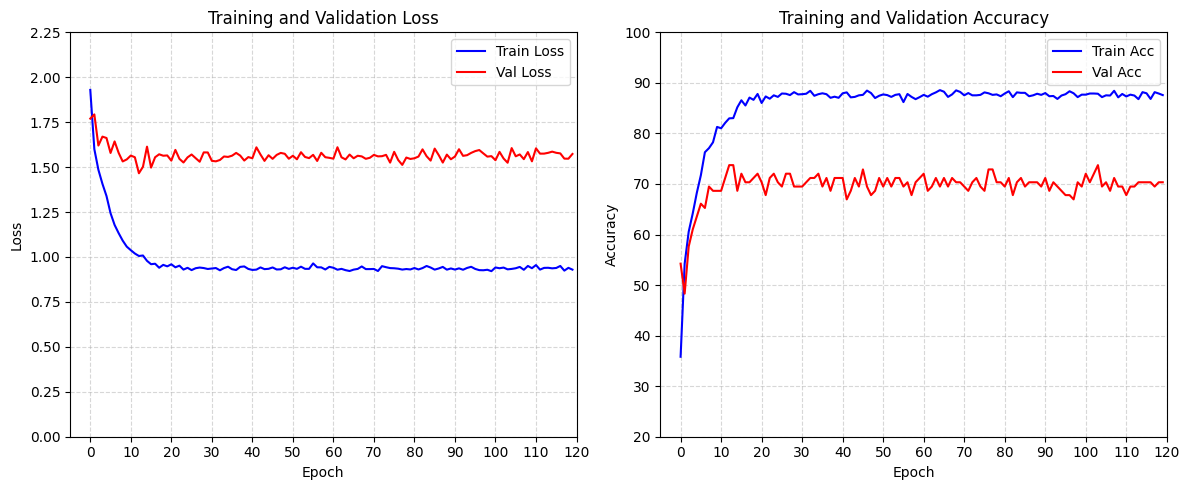

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(arr_train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(arr_val_loss, label='Val Loss', color='red', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(start=0, stop=len(arr_train_loss)+1, step=10))
plt.xlim(-5, len(arr_train_loss))
plt.yticks(np.arange(start=0, stop=max(arr_train_loss) + 0.5, step=0.25))

plt.subplot(1, 2, 2)
plt.plot(arr_train_acc, label='Train Acc', color='blue', linestyle='-')
plt.plot(arr_val_acc, label='Val Acc', color='red', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(start=0, stop=len(arr_train_loss)+1, step=10))
plt.xlim(-5, len(arr_train_loss))
plt.yticks(np.arange(start=max(min(arr_train_acc)//10*10-10, 0), stop=max(arr_train_acc)//10*10+30, step=10))


plt.tight_layout()
plt.savefig('loss_acc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# TODO: Save model parameter states
# TODO: Save training log data as CSV file

In [18]:
# iteration 6 template 2
# Updates:
# 1. Abandon preloading train data to device
# 2. Redo data augmentation/transformation
# 3. Adjust hyperparameters
# 4. Fix variable names in cells
# 5. Add plot output